In [62]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\Lewis\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\Lewis\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': 'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# safe imports
import sys                  # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    import pystac_client
    from odc import stac
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    import cog_odc, canopy, nicher
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise

In [10]:
import os
import rasterio

os.environ

#os.environ['GDAL_DISABLE_READDIR_ON_OPEN']
os.environ['VSI_CACHE']

'TRUE'

In [63]:
# imports
import os
import shutil
import tempfile
import certifi
import arcpy

In [106]:
from importlib import reload
reload(arc)

<module 'arc' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\shared\\arc.py'>

In [5]:
# set default gdal and certifi envs... improve?
os.environ['GDAL_DATA']  = r'C:\Program Files\ArcGIS\Pro\Resources\pedata\gdaldata'
os.environ.setdefault("CURL_CA_BUNDLE", certifi.where())

'C:\\Users\\Lewis\\AppData\\Roaming\\.certifi\\cacert.pem'

In [6]:
# create roi tool
# todo - want soemthing basic but interact. c#?
# user will draw shapes, assign attributes, save, etc


In [7]:
# loop each ewmacd output and detect traffic lights
# need to experiment here

In [8]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# testing: load dataset
#ds = xr.open_dataset(r"E:\Curtin\GDVII - General\Work Package 2\Analysis\EWMACD\yandi pump\yandi_pump_train_90_95_per1_clean.nc")

In [63]:
#test = [10, 20]
test = [30, 20]

vec = ds['change'].isel(x=test[0], y=test[1])
raise

# create neg only mask
n_vec = vec.copy(deep=True)  
n_vec.data = vec < 0
n_vec = n_vec.astype(int) #* -1

# create smoothed original vec
s_vec = vec.copy(deep=True)
s_vec.data = savgol_filter(vec, 99, 1)

vec.plot()
s_vec.plot()
n_vec.plot()

plt.show()

RuntimeError: No active exception to reraise

In [106]:
# globals (dev)
FOLDER_MODULES = r'C:\Users\262272G\Documents\GitHub\tenement-tools\modules'  
FOLDER_SHARED = r'C:\Users\262272G\Documents\GitHub\tenement-tools\shared'
GRP_LYR_FILE = r"C:\Users\262272G\Documents\GitHub\tenement-tools\arc\lyr\group_template.lyrx"

# set gdal global environ
import os
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS '] = 'tif'
os.environ['VSI_CACHE '] = 'TRUE'
os.environ['GDAL_HTTP_MULTIRANGE '] = 'YES'
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES '] = 'YES'

# also set rasterio env variables
rasterio_env = {
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS':'tif',
    'VSI_CACHE': True,
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES'
}

# disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# safe imports
import sys                  # arcgis comes with these
import datetime                 # arcgis comes with these
import numpy as np              # arcgis comes with these
import arcpy                    # arcgis comes with these
from datetime import datetime   # arcgis comes with these

# risky imports (not native to arcgis)
try:
    import xarray as xr
    import dask
    import rasterio
    #import pystac_client
    #from odc import stac
except:
    arcpy.AddError('Python libraries xarray, dask, rasterio, pystac, or odc not installed.')
    raise

# import tools
try:
    # shared folder
    sys.path.append(FOLDER_SHARED)
    import arc, satfetcher, tools

    # module folder
    sys.path.append(FOLDER_MODULES)
    #import cog_odc
except:
    arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
    raise

## LOESS filter for curve fit, works quick and nice

In [4]:
ds = xr.open_dataset(r"E:\Curtin\GDVII - General\Work Package 2\Analysis\EWMACD\opthal\opthal_90_2020_1MS_landsat.nc")

In [14]:
from math import ceil
import numpy as np
from scipy import linalg

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    
    yest = np.zeros(n)
    delta = np.ones(n)
    
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

D66140B0-0277-45FF-AE18-A787BE3D4AAF:36: RuntimeWarning: divide by zero encountered in true_divide
D66140B0-0277-45FF-AE18-A787BE3D4AAF:36: RuntimeWarning: invalid value encountered in true_divide


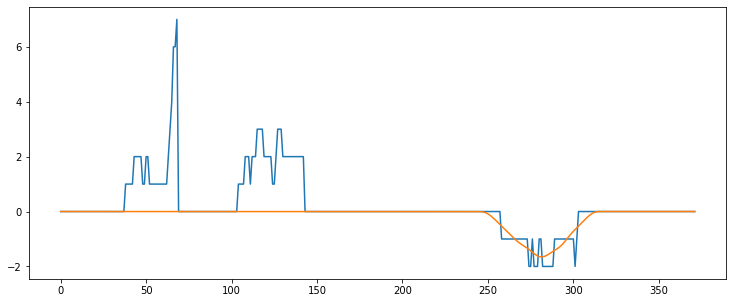

In [15]:
ds = xr.open_dataset(r"E:\Curtin\GDVII - General\Work Package 2\Analysis\EWMACD\yandi pump\yandi_pump_train_90_95_per1_clean.nc")

vec = ds.isel(x=0, y=30).compute()

f = 0.075  # smooth %

x = np.arange(0, len(vec['time']))
y = vec['change'].values

y = np.where(y > 0, 0, y)

yest = lowess_ag(x, y, f=f, iter=1)

%matplotlib inline
plt.figure(figsize=(12.5, 5))
plt.plot(vec['change'])
plt.plot(yest)
plt.show()

D66140B0-0277-45FF-AE18-A787BE3D4AAF:1: RuntimeWarning: divide by zero encountered in true_divide
D66140B0-0277-45FF-AE18-A787BE3D4AAF:1: RuntimeWarning: invalid value encountered in true_divide


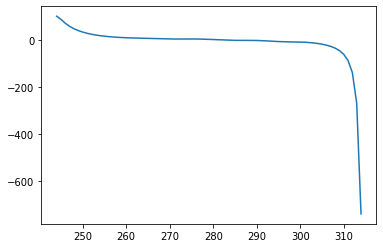

In [159]:
pct = np.diff(yest) / yest[1:, ] * 100
plt.plot(pct)
plt.show()

D66140B0-0277-45FF-AE18-A787BE3D4AAF:1: RuntimeWarning: invalid value encountered in true_divide


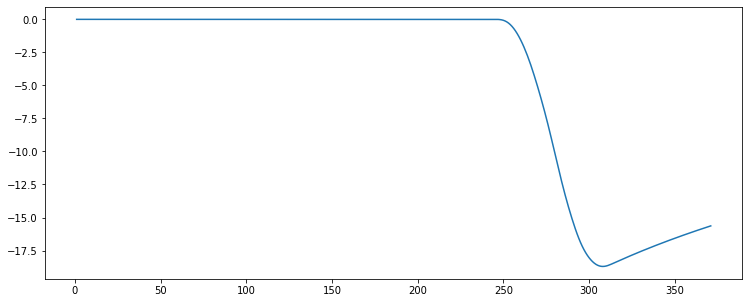

In [23]:
cumavg = np.cumsum(yest) / np.arange(0, len(yest)) * 100

%matplotlib inline
plt.figure(figsize=(12.5, 5))
plt.plot(cumavg)
plt.show()

In [ ]:
def execute(self, parameters, messages):
    """
    Executes the Ensemble Sigmoider module.
    """

    # safe imports
    import os             # arcgis comes with these
    import datetime       # arcgis comes with these

    # risky imports (not native to arcgis)
    try:
        import numpy as np
        import xarray as xr
    except:
        arcpy.AddError('Python libraries xarray and dask not installed.')
        return

    # import tools
    try:
        # shared folder
        sys.path.append(FOLDER_SHARED)
        import arc, satfetcher, tools

        # module folder
        sys.path.append(FOLDER_MODULES)
        import canopy
    except:
        arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
        return

    # disable future warnings
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=RuntimeWarning)

    # grab parameter values 
    in_file = parameters[0].valueAsText          # input netcdf or geotiff
    out_nc = parameters[1].valueAsText           # output netcdf
    in_var = parameters[2].value                 # input variable
    in_type = parameters[3].value                # input membership type
    in_min = parameters[4].value                 # input minimum
    in_max = parameters[5].value                 # input maximum
    in_add_result_to_map = parameters[6].value   # input add result to map



    # # # # #
    # notify user and set up progress bar
    arcpy.AddMessage('Beginning Ensemble Sigmoider.')
    arcpy.SetProgressor(type='step', 
                        message='Preparing parameters...',
                        min_range=0, max_range=7)

    # prepare and check file extension
    in_ext = os.path.splitext(in_file)[1]
    if in_ext not in ['.nc', '.tif']:
        arcpy.AddError('File type not supported.')
        return

    # check type
    if in_type not in ['Increasing', 'Decreasing', 'Symmetric']:
        arcpy.AddError('Membership type not supported.')
        return

    # check values 
    if in_min is None or in_max is None:
        arcpy.AddError('Low and high inflection points must not be empty.')
        return
    elif in_max <= in_min:
        arcpy.AddError('High inflection point can not be <= low inflection.')
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Loading and checking input data...')
    arcpy.SetProgressorPosition(1)

    # do quick load depending on input type
    try:
        if in_ext == '.nc':
            ds = xr.open_dataset(in_file)
        else:
            ds = xr.open_rasterio(in_file)
            ds = ds.to_dataset(dim='band')
            ds = tools.build_xr_attributes(ds)   
    except:
        arcpy.AddError('Could not quick load input file.')
        return

    # check xr type, vars, coords, dims, attrs
    if not isinstance(ds, xr.Dataset):
        arcpy.AddError('Input NetCDF must be a xr dataset.')
        return
    elif 'time' in ds:
        arcpy.AddError('Input NetCDF time dimension must not exist.')
        return
    elif len(ds) == 0:
        arcpy.AddError('Input NetCDF has no data/variables/bands.')
        return
    elif in_ext == '.tif' and len(ds) > 1:
        arcpy.AddError('Input GeoTiff must have only one band.')
        return
    elif 'x' not in list(ds.coords) or 'y' not in list(ds.coords):
        arcpy.AddError('Input NetCDF must have x, y coords.')
        return
    elif 'spatial_ref' not in list(ds.coords):
        arcpy.AddError('Input NetCDF must have a spatial_ref coord.')
        return
    elif 'x' not in list(ds.dims) or 'y' not in list(ds.dims):
        arcpy.AddError('Input NetCDF must have x, y dimensions.')
        return
    elif len(ds['x']) == 0 or len(ds['y']) == 0:
        arcpy.AddError('Input NetCDF must have at least one x, y index.')
        return
    elif ds.attrs == {}:
        arcpy.AddError('NetCDF attributes not found. NetCDF must have attributes.')
        return
    elif not hasattr(ds, 'crs'):
        arcpy.AddError('NetCDF CRS attribute not found. CRS required.')
        return
    elif ds.crs != 'EPSG:3577':
        arcpy.AddError('NetCDF CRS is not EPSG:3577. EPSG:3577 required.')            
        return
    elif not hasattr(ds, 'nodatavals'):
        arcpy.AddError('NetCDF nodatavals attribute not found.')            
        return

    # check if xr is all nan/0 via centroid pixel timeseries (saves full load)
    if ds.to_array().isnull().all():
        arcpy.AddError('Input data is completely null.')            
        return 

    try:
        # now, do proper open of file, set nodata to nan
        if in_ext == '.nc':
            ds = satfetcher.load_local_nc(nc_path=in_file, 
                                          use_dask=False, 
                                          conform_nodata_to=np.nan)
        else:
            ds = satfetcher.load_local_rasters(rast_path_list=in_file, 
                                               use_dask=False, 
                                               conform_nodata_to=np.nan)
            ds = tools.build_xr_attributes(ds) 
    except:
        arcpy.AddError('Could not properly load input file.')
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Getting file attributes...')
    arcpy.SetProgressorPosition(2)

    # get attributes from dataset
    ds_attrs = ds.attrs
    ds_band_attrs = ds[list(ds.data_vars)[0]].attrs
    ds_spatial_ref_attrs = ds['spatial_ref'].attrs



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Subsetting data to specified variable...')
    arcpy.SetProgressorPosition(3)

    # check if requested var in netcdf (tif always has one)
    if in_ext == '.nc' and in_var not in ds:
        arcpy.AddError('Requested variable not found in NetCDF.')
        return

    # subset dataset if netcdf (tif always have one), set both as array
    ds = ds[in_var] if in_ext == '.nc' else ds.to_array()



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Applying sigmoidal function to data...')
    arcpy.SetProgressorPosition(3)

    # get nan mask
    ds_mask = xr.where(~ds.isnull(), True, False)

    try:
        # apply sigmoidal depending on user selection
        if in_type == 'Increasing':
            ds = canopy.inc_sigmoid(ds, a=in_min, b=in_max)
        elif in_type == 'Decreasing':
            ds = canopy.dec_sigmoid(ds, c=in_min, d=in_max)
        elif in_type == 'Symmetric':
            ds = canopy.bell_sigmoid(ds, a=in_min, bc=in_max, d=in_min)
    except:
        arcpy.AddError('Could not perform signoidal.')
        return


    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Cleaning up output dataset...')
    arcpy.SetProgressorPosition(4)

    # apply nan mask to be safe
    ds = ds.where(ds_mask)

    # name single variable to sigmoid
    ds = ds.to_dataset(name='sigmoid').squeeze(drop=True)



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Appending attributes back on to dataset...')
    arcpy.SetProgressorPosition(5)

    # append attrbutes on to dataset and bands
    ds.attrs = ds_attrs
    ds['spatial_ref'].attrs = ds_spatial_ref_attrs
    for var in list(ds.data_vars):
        ds[var].attrs = ds_band_attrs

    # now that we have forced nan as nodata, update attribute 
    ds.attrs.update({'nodatavals': np.nan})



    # # # # #
    # notify and increment progess bar
    arcpy.SetProgressorLabel('Exporting NetCDF file...')
    arcpy.SetProgressorPosition(6)   

    # export netcdf file
    tools.export_xr_as_nc(ds=ds, filename=out_nc)



    # # # # #
    # add to map if requested
    if in_add_result_to_map:

        # notify and increment progress bar
        arcpy.SetProgressorLabel('Adding sigmoidal to map...')
        arcpy.SetProgressorPosition(8)

        try:
            # open current map
            aprx = arcpy.mp.ArcGISProject('CURRENT')
            m = aprx.activeMap

            # remove sigmoidal layer if exists
            for layer in m.listLayers():
                if layer.name == 'sigmoid.crf':
                    m.removeLayer(layer)

            # create output folder using datetime as name
            dt = datetime.datetime.now().strftime('%d%m%Y%H%M%S')
            out_folder = os.path.join(os.path.dirname(out_nc), 'sigmoid' + '_' + dt)
            os.makedirs(out_folder)

            # disable visualise on map temporarily
            arcpy.env.addOutputsToMap = False

            # create crf filename and copy it
            out_file = os.path.join(out_folder, 'sigmoid.crf')
            crf = arcpy.CopyRaster_management(in_raster=out_nc, 
                                              out_rasterdataset=out_file)

            # add to map                  
            m.addDataFromPath(crf)   

        except:
            arcpy.AddWarning('Could not visualise output. Aborting visualisation.')

        try:
            # get symbology, update it
            layer = m.listLayers('sigmoid.crf')[0]
            sym = layer.symbology

            # if layer has stretch coloriser, apply color
            if hasattr(sym, 'colorizer'):
                if sym.colorizer.type == 'RasterStretchColorizer':

                    # apply percent clip type
                    sym.colorizer.stretchType = 'PercentClip'
                    sym.colorizer.minPercent = 0.01
                    sym.colorizer.maxPercent = 0.99

                    # apply color map
                    cmap = aprx.listColorRamps('Spectrum By Wavelength-Full Bright')[0]
                    sym.colorizer.colorRamp = cmap

                    # apply other basic options
                    sym.colorizer.invertColorRamp = False
                    sym.colorizer.gamma = 1.0

                    # update symbology
                    layer.symbology = sym

        except:
            arcpy.AddWarning('Could not visualise layer GeoTiffs.')



    # # # # #
    # clean up variables
    arcpy.SetProgressorLabel('Finalising process...')
    arcpy.SetProgressorPosition(7)

    # close main dataset
    ds.close()
    del ds

    # close mask dataset
    ds_mask.close()
    del ds_mask

    # notify user
    arcpy.AddMessage('Generated Sigmoidal successfully.')

    return

In [ ]:
def execute(self, parameters, messages):
    """
    Executes the Ensemble Model module.
    """

    # safe imports
    import os             # arcgis comes with these
    import datetime       # arcgis comes with these
    import tempfile       # arcgis comes with these

    # risky imports (not native to arcgis)
    try:
        import numpy as np
        import xarray as xr
    except:
        arcpy.AddError('Python libraries xarray and dask not installed.')
        return

    # import tools
    try:
        # shared folder
        sys.path.append(FOLDER_SHARED)
        import arc, satfetcher, tools

        # module folder
        sys.path.append(FOLDER_MODULES)
        import canopy, ensemble
    except:
        arcpy.AddError('Could not find tenement tools python scripts (modules, shared).')
        return

    # disable future warnings
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=RuntimeWarning)

    # grab parameter values 
    in_layers = parameters[0].value              # input layers (value array)
    out_nc = parameters[1].valueAsText           # output netcdf
    in_resample = parameters[2].value            # resample resolution
    in_win_size = parameters[3].value            # smoothing window size
    in_add_result_to_map = parameters[4].value   # add result to map



    # # # # #
    # notify user and set up progress bar
    arcpy.AddMessage('Beginning Ensemble Modelling.')
    arcpy.SetProgressor(type='step', 
                        message='Preparing parameters...',
                        min_range=0, max_range=9)

    # check layers isnt empty
    if len(in_layers) == 0:
        arcpy.AddError('No fuzzy layers provided.')
        return

    # get all layers types and check
    layer_types = [layer[1] for layer in in_layers]
    if 'Belief' not in layer_types:
        arcpy.AddError('Layers must have at least one Belief layer.')
        return
    elif 'Disbelief' not in layer_types:
        arcpy.AddError('Layers must have at least one Disbelief layer.')
        return
    elif len(np.unique(layer_types)) != 2:
        arcpy.AddError('Layers must have only contain Belief and Disbelief types.')
        return

    # check resample
    if in_resample not in ['Lowest Resolution', 'Highest Resolution']:
        arcpy.AddWarning('Resample type not supported, setting to default.')
        in_resample = 'Lowest Resolution'

    # check smooth window size (we support none, for no smoothing)
    if in_win_size is not None:
        if not isinstance(in_win_size, int):
            arcpy.AddWarning('Smoothing window size must be integer, setting to default.')
            in_win_size = 3
        elif in_win_size < 3:
            arcpy.AddWarning('Smoothing window size must be 3 or above, setting to default.')
            in_win_size = 3



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Checking and loading input datasets...')
    arcpy.SetProgressorPosition(1)

    # iterate layers for check
    ds_list = []
    for layer in in_layers:        
        try:
            ds = xr.open_dataset(layer[0].value)                
        except:
            arcpy.AddError('Could not load input NetCDF {}.'.format(layer[0].value))
            return

        # check xr type, vars, coords, dims, attrs
        if not isinstance(ds, xr.Dataset):
            arcpy.AddError('Input NetCDF must be a xr dataset.')
            return
        elif 'sigmoid' not in ds:
            arcpy.AddError('Input NetCDF does not contain a sigmoid variable.')
            return
        elif 'time' in ds and ds['time'] > 1:
            arcpy.AddError('Input NetCDF must not have a time dimension.')
            return
        elif len(ds.data_vars) == 0:
            arcpy.AddError('Input NetCDF has no data/variables/bands.')
            return
        elif 'x' not in list(ds.coords) or 'y' not in list(ds.coords):
            arcpy.AddError('Input NetCDF must have x, y coords.')
            return
        elif 'spatial_ref' not in list(ds.coords):
            arcpy.AddError('Input NetCDF must have a spatial_ref coord.')
            return
        elif 'x' not in list(ds.dims) or 'y' not in list(ds.dims):
            arcpy.AddError('Input NetCDF must have x, y dimensions.')
            return
        elif len(ds['x']) == 0 or len(ds['y']) == 0:
            arcpy.AddError('Input NetCDF must have at least one x, y index.')
            return
        elif ds.attrs == {}:
            arcpy.AddError('NetCDF attributes not found. NetCDF must have attributes.')
            return
        elif not hasattr(ds, 'crs'):
            arcpy.AddError('NetCDF CRS attribute not found. CRS required.')
            return
        elif ds.crs != 'EPSG:3577':
            arcpy.AddError('NetCDF CRS is not EPSG:3577. EPSG:3577 required.')            
            return
        elif not hasattr(ds, 'nodatavals'):
            arcpy.AddError('NetCDF nodatavals attribute not found.')            
            return

        # check if xr is all nan
        if ds.to_array().isnull().all():
            arcpy.AddError('Input data is completely null.')            
            return

        try:
            # do proper load with dask, set nodata to nan
            ds = satfetcher.load_local_nc(nc_path=layer[0].value, 
                                          use_dask=True, 
                                          conform_nodata_to=np.nan)
        except:
            arcpy.AddError('Could not properly load input file.')
            return

        # add belief type to ds, will be striped later
        ds.attrs.update({'evi_type': layer[1]})

        # add to dataset list
        ds_list.append(ds)

    # check at least one belief and disbelief layer captured
    if len(ds_list) == 0:
        arcpy.AddError('Insufficient processed datasets.')            
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Checking dataset extents intersect...')
    arcpy.SetProgressorPosition(2)

    # check extents overlap
    if not tools.all_xr_intersect(ds_list):
        arcpy.AddError('Not all input layers intersect.')            
        return 



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Conforming datasets via resampling...')
    arcpy.SetProgressorPosition(3)

    # select target resolution dataset
    ds_target = ensemble.get_target_res_xr(ds_list, in_resample)

    # check if somethign returned
    if ds_target is None:
        arcpy.AddError('Could not obtain optimal resolution dataset.')            
        return    

    try:
        # resample all datasets to target dataset
        for idx in range(len(ds_list)):
            ds_list[idx] = tools.resample_xr(ds_from=ds_list[idx], 
                                             ds_to=ds_target,
                                             resampling='nearest')

            # squeeze 
            ds_list[idx] = ds_list[idx].squeeze(drop=True)

    except:
        arcpy.AddError('Could not resmaple datasets.')
        return 



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Smoothing datasets, if requested...')
    arcpy.SetProgressorPosition(4)

    # smooth each dataset, if requested
    if in_win_size is not None:
        try:
            # smooth each dataset, eject if none (error)
            for idx in range(len(ds_list)):
                ds_list[idx] = ensemble.smooth_xr_dataset(ds_list[idx], in_win_size)

                if ds_list[idx] is None:
                    arcpy.AddError('Could not smooth datasets.')
                    return
        except:
            arcpy.AddError('Could not smooth datasets.')
            return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Loading datasets into memory, please wait...')
    arcpy.SetProgressorPosition(5)

    # load each dataset
    for ds in ds_list: 
        ds.load()



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Splitting datasets into belief and disbelief...')
    arcpy.SetProgressorPosition(5)

    # split datasets via evidence type attribute
    beliefs = [ds for ds in ds_list if ds.evi_type == 'Belief']
    disbeliefs = [ds for ds in ds_list if ds.evi_type == 'Disbelief']  

    # check something was returned for each
    if len(beliefs) == 0 or len(disbeliefs) == 0:
        arcpy.AddError('Could not split datasets into belief and disbelief.')
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Performing ensemble modelling...')
    arcpy.SetProgressorPosition(6)

    try:
        # perfom ensemble modelling
        ds = ensemble.perform_modelling(belief=beliefs,
                                        disbelief=disbeliefs)

        # create and add attributes to dataset
        ds = tools.manual_create_xr_attrs(ds)

        # add nodatavals attribute, as we used nan 
        ds.attrs.update({'nodatavals': np.nan})

    except:
        arcpy.AddError('Could not perform ensemble modelling.')
        return

    # check if dataset exists
    if ds is None:
        arcpy.AddError('No result was produced from ensemble modelling.')
        return



    # # # # #
    # notify and increment progress bar
    arcpy.SetProgressorLabel('Exporting NetCDF file...')
    arcpy.SetProgressorPosition(7)

    # export netcdf file
    tools.export_xr_as_nc(ds=ds, filename=out_nc)



    # # # # #
    # add multi-dim raster to current map
    if in_add_result_to_map:

        # notify and increment progess bar
        arcpy.SetProgressorLabel('Adding outputs to current map...')
        arcpy.SetProgressorPosition(8)

        # create output folder with dt
        dt = datetime.datetime.now().strftime("%d%m%Y%H%M%S")
        out_folder = os.path.join(os.path.dirname(out_nc), 'ensemble' + '_' + dt)
        os.makedirs(out_folder)

        try:
            # open current map
            aprx = arcpy.mp.ArcGISProject('CURRENT')
            m = aprx.activeMap

            # remove existing ensemble layers if exist
            for layer in m.listLayers():
                if layer.isGroupLayer and layer.name == 'ensemble':
                    m.removeLayer(layer)

            # setup a group layer via template
            grp_lyr = arcpy.mp.LayerFile(GRP_LYR_FILE)
            grp = m.addLayer(grp_lyr)[0]
            grp.name = 'ensemble'

            # disable visual add to map
            arcpy.env.addOutputsToMap = False

            # loop each var and export a seperate crf
            tif_list = []
            for var in ds:      

                # create temporary netcdfil for one var (prevents 2.9 bug)
                with tempfile.NamedTemporaryFile() as tmp:
                    tmp_nc = '{}_{}.nc'.format(tmp.name, var)
                    ds[[var]].to_netcdf(tmp_nc)

                # build in-memory crf for temp netcdf
                crf = arcpy.md.MakeMultidimensionalRasterLayer(in_multidimensional_raster=tmp_nc, 
                                                               out_multidimensional_raster_layer=var)

                # export temp tif
                tmp_tif = os.path.join(out_folder, '{}.tif'.format(var))
                arcpy.management.CopyRaster(in_raster=crf, out_rasterdataset=tmp_tif)

                # add temp tif to map abd get as layer
                m.addDataFromPath(tmp_tif)
                layer = m.listLayers('{}.tif'.format(var))[0]

                # add layer to group and then remove outside layer
                m.addLayerToGroup(grp, layer, 'BOTTOM')
                m.removeLayer(layer) 

                # success, add store current layer for symbology below
                tif_list.append('{}.tif'.format(var))

        except:
            arcpy.AddWarning('Could not create layer GeoTiffs.')

        try:       
            # iter tif layer names, get symbology, update it
            for tif in tif_list:
                layer = m.listLayers(tif)[0]
                sym = layer.symbology

                # if layer has stretch coloriser, apply color
                if hasattr(sym, 'colorizer'):
                    if sym.colorizer.type == 'RasterStretchColorizer':

                        # apply percent clip type
                        sym.colorizer.stretchType = 'PercentClip'
                        sym.colorizer.minPercent = 0
                        sym.colorizer.maxPercent = 1

                        # apply color map
                        cmap = aprx.listColorRamps('Spectrum By Wavelength-Full Bright')[0]
                        sym.colorizer.colorRamp = cmap

                        # apply other basic options
                        sym.colorizer.invertColorRamp = False
                        sym.colorizer.gamma = 1.0

                        # update symbology
                        layer.symbology = sym
        except:
            arcpy.AddWarning('Could not visualise layer GeoTiffs.')



    # # # # #
    # clean up variables
    arcpy.SetProgressorLabel('Finalising process...')
    arcpy.SetProgressorPosition(9)

    # close ensemble dataset 
    ds.close()
    del ds

    # close all xr datasets in input lists
    for ds in ds_list + beliefs + disbeliefs:
        ds.close()

    # notify user
    arcpy.AddMessage('Performed Ensemble Modelling successfully.')

    return

In [5]:
import pandas as pd

In [ ]:
# remove extra trees
# remove replicates

In [6]:
from importlib import reload
reload(nicher)

<module 'nicher' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\nicher.py'>

In [65]:
from importlib import reload
reload(cog_odc)

<module 'cog_odc' from 'C:\\Users\\Lewis\\Documents\\GitHub\\tenement-tools\\modules\\cog_odc.py'>

In [2]:
import xarray as xr

xr.open_dataset(r"C:\Users\Lewis\Desktop\test\_unit16.nc")

<xarray.Dataset>
Dimensions:       (time: 717, x: 193, y: 102)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-05T01:48:07 ... 2019-12-28T01...
  * y             (y) float64 -1.959e+06 -1.959e+06 ... -1.962e+06 -1.962e+06
  * x             (x) float64 -9.976e+05 -9.976e+05 ... -9.919e+05 -9.919e+05
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) uint16 ...
    nbart_green   (time, y, x) uint16 ...
    nbart_red     (time, y, x) uint16 ...
    nbart_nir     (time, y, x) uint16 ...
    nbart_swir_1  (time, y, x) uint16 ...
    nbart_swir_2  (time, y, x) uint16 ...
    oa_fmask      (time, y, x) uint16 ...
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref